In [ ]:
from __future__ import print_function, division

import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
from torchvision import models
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import math

batch_size = 32
learning_rate = 0.0002
Epoch = 100
TRAIN = True
dataPath = '../DBtest/img/'
checkPointPath = '../DBtest/checkPoint/ResNet_checkPoint/'

train_transforms = transforms.Compose([
    # transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])
test_transforms = transforms.Compose([
    # transforms.Resize(256),
    # transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])
val_transforms = transforms.Compose([
    # transforms.Resize(256),
    # transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

train_dir = dataPath + 'train'
train_datasets = datasets.ImageFolder(train_dir, transform=train_transforms)
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True)

test_dir = dataPath + 'test'
test_datasets = datasets.ImageFolder(test_dir, transform=test_transforms)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=batch_size, shuffle=True)

val_dir = dataPath + 'val'
val_datasets = datasets.ImageFolder(val_dir, transform=val_transforms)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size, shuffle=True)

  # --------------------模型定义---------------------------------
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet, self).__init__()
        net = models.resnet50(pretrained=False)
        channel_in = net.fc.in_features
        net.fc = nn.Sequential()
        self.features = net
        self.classifier = nn.Sequential(
            nn.Linear(channel_in, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

  # --------------------训练过程---------------------------------
model = ResNet()
if torch.cuda.is_available():
    model.cuda()
    print('Using GPU')

params = [{'params': md.parameters()} for md in model.children()
          if md in [model.classifier]]
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()
start_epoch = 0

if os.path.exists(checkPointPath + 'ResNet_best_19.pth'):
    path_checkpoint = checkPointPath + 'ResNet_best_19.pth'  # 断点路径
    checkpoint = torch.load(path_checkpoint)  # 加载断点
    model.load_state_dict(checkpoint['net'])  # 加载模型可学习参数
    optimizer.load_state_dict(checkpoint['optimizer'])  # 加载优化器参数
    start_epoch = checkpoint['epoch'] + 1  # 设置开始的epoch

if TRAIN:
  if os.path.exists(checkPointPath + 'loss.npy'):
    Loss_list = np.load(checkPointPath + 'loss.npy', allow_pickle=True)
  else:
    Loss_list = []

  if os.path.exists(checkPointPath + 'accuracy.npy'):
    Accuracy_list = np.load(checkPointPath + 'accuracy.npy', allow_pickle=True)
  else:
    Accuracy_list = []

  for epoch in range(start_epoch, Epoch):
    print('epoch {}'.format(epoch))
    # training-----------------------------
    model.train()
    train_loss = 0.
    train_acc = 0.
    print('Training...')
    trainBar = tqdm(total=len(train_dataloader))
    for step, (batch_x, batch_y) in enumerate(train_dataloader):
      if torch.cuda.is_available():
        batch_x, batch_y = Variable(batch_x).cuda(), Variable(batch_y).cuda()
      else:
        batch_x, batch_y = Variable(batch_x), Variable(batch_y)
      out = model(batch_x)
      loss = loss_func(out, batch_y)
      train_loss += loss.data
      pred = torch.max(out, 1)[1]
      train_correct = (pred == batch_y).sum()
      train_acc += train_correct.data
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      trainBar.update(1)
    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / len(train_datasets), train_acc / len(train_datasets)))
    trainBar.close()

    # 断点保存
    checkpoint = {
        "net": model.state_dict(),
        'optimizer':optimizer.state_dict(),
        "epoch": epoch
    }
    torch.save(checkpoint, checkPointPath + 'ResNet_best_%s.pth' %(str(epoch)))

    # evaluation--------------------------------
    model.eval()
    eval_loss = 0.
    eval_acc = 0.
    print('Testing...')
    testBar = tqdm(total=len(val_dataloader))
    for batch_x, batch_y in val_dataloader:
      with torch.no_grad():
        if torch.cuda.is_available():
          batch_x, batch_y = Variable(batch_x).cuda(), Variable(batch_y).cuda()
        else:
          batch_x, batch_y = Variable(batch_x), Variable(batch_y)
      out = model(batch_x)
      loss = loss_func(out, batch_y)
      eval_loss += loss.data
      pred = torch.max(out, 1)[1]
      num_correct = (pred == batch_y).sum()
      eval_acc += num_correct.data
      testBar.update(1)
    print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / len(val_datasets), eval_acc / len(val_datasets)))
    testBar.close()

    # 断点保存
    if epoch >= len(Loss_list):
        Loss_list = np.hstack((Loss_list, eval_loss.data.cpu() / len(val_datasets)))
        Accuracy_list = np.hstack((Accuracy_list, 100 * eval_acc.data.cpu() / len(val_datasets)))
    else:
        Loss_list[epoch] = eval_loss.data.cpu() / len(val_datasets)
        Accuracy_list[epoch] = 100 * eval_acc.data.cpu() / len(val_datasets)

    np.save(checkPointPath + 'loss', Loss_list)
    np.save(checkPointPath + 'accuracy', Accuracy_list)

  x1 = range(0, 10)
  x2 = range(0, 10)
  y1 = Accuracy_list
  y2 = Loss_list
  plt.subplot(2, 1, 1)
  plt.plot(x1, y1, 'o-')
  plt.title('Test accuracy vs. epoches')
  plt.ylabel('Test accuracy')
  plt.subplot(2, 1, 2)
  plt.plot(x2, y2, '.-')
  plt.xlabel('Test loss vs. epoches')
  plt.ylabel('Test loss')
  plt.show()
  # plt.savefig("accuracy_loss.jpg")

else:
  model.eval()
  eval_loss = 0.
  eval_acc = 0.
  print('Testing...')
  testBar = tqdm(total=len(test_dataloader))
  for batch_x, batch_y in test_dataloader:
    with torch.no_grad():
      if torch.cuda.is_available():
        batch_x, batch_y = Variable(batch_x).cuda(), Variable(batch_y).cuda()
      else:
        batch_x, batch_y = Variable(batch_x), Variable(batch_y)
    out = model(batch_x)
    loss = loss_func(out, batch_y)
    eval_loss += loss.data
    pred = torch.max(out, 1)[1]
    num_correct = (pred == batch_y).sum()
    eval_acc += num_correct.data
    testBar.update(1)
  print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / len(test_datasets), eval_acc / len(test_datasets)))
  testBar.close()

Using GPU
epoch 20
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.010302, Acc: 0.878889
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.015031, Acc: 0.826318
epoch 21
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.009850, Acc: 0.885055
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.019729, Acc: 0.787131
epoch 22
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.009941, Acc: 0.882862
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.014048, Acc: 0.839865
epoch 23
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.009087, Acc: 0.895854
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.014441, Acc: 0.823416
epoch 24
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.008998, Acc: 0.895606
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.015168, Acc: 0.836478
epoch 25
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.008518, Acc: 0.903592
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.014880, Acc: 0.841316
epoch 26
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.008303, Acc: 0.905536
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.015975, Acc: 0.840348
epoch 27
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.008212, Acc: 0.906198
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.013671, Acc: 0.848573
epoch 28
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.007666, Acc: 0.913398
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.016421, Acc: 0.835510
epoch 29
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.007524, Acc: 0.914350
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.014800, Acc: 0.843735
epoch 30
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.007170, Acc: 0.919273
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.014923, Acc: 0.851476
epoch 31
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.007289, Acc: 0.919191
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.014825, Acc: 0.840348
epoch 32
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.006917, Acc: 0.922294
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.015847, Acc: 0.825351
epoch 33
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.006360, Acc: 0.928956
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.015732, Acc: 0.848089
epoch 34
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.006426, Acc: 0.928956
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.014782, Acc: 0.848573
epoch 35
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.006083, Acc: 0.932555
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.017164, Acc: 0.852927
epoch 36
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.006376, Acc: 0.931024
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.015401, Acc: 0.852443
epoch 37
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.005598, Acc: 0.938638
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.018099, Acc: 0.863087
epoch 38
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.005805, Acc: 0.937272
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.014915, Acc: 0.862603
epoch 39
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.005920, Acc: 0.933176
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.015775, Acc: 0.864538
epoch 40
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.005579, Acc: 0.942362
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.018641, Acc: 0.848573
epoch 41
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.005395, Acc: 0.941617
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.019104, Acc: 0.824383
epoch 42
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.005358, Acc: 0.942776
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.016276, Acc: 0.864538
epoch 43
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.005085, Acc: 0.943727
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.015816, Acc: 0.870344
epoch 44
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.005122, Acc: 0.946913
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.015370, Acc: 0.870344
epoch 45
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.005051, Acc: 0.946706
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.015422, Acc: 0.856314
epoch 46
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.004887, Acc: 0.945920
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.017843, Acc: 0.858249
epoch 47
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.004808, Acc: 0.948362
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.017660, Acc: 0.848089
epoch 48
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.004718, Acc: 0.951217
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.016968, Acc: 0.853411
epoch 49
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.004361, Acc: 0.953782
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.016407, Acc: 0.869376
epoch 50
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.004435, Acc: 0.952996
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.016384, Acc: 0.872279
epoch 51
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.004441, Acc: 0.953409
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.016895, Acc: 0.869860
epoch 52
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.004395, Acc: 0.952623
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.017016, Acc: 0.857281
epoch 53
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.004453, Acc: 0.952665
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.016103, Acc: 0.872763
epoch 54
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.004361, Acc: 0.956058
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.017287, Acc: 0.866473
epoch 55
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.004212, Acc: 0.957671
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.018289, Acc: 0.857765
epoch 56
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.004304, Acc: 0.956058
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.018713, Acc: 0.859216
epoch 57
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.004172, Acc: 0.957630
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.019642, Acc: 0.855346
epoch 58
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.003756, Acc: 0.960609
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.020845, Acc: 0.854378
epoch 59
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.003948, Acc: 0.958292
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.017663, Acc: 0.863087
epoch 60
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.004002, Acc: 0.956844
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.017054, Acc: 0.870827
epoch 61
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.003606, Acc: 0.961975
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.017366, Acc: 0.879052
epoch 62
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.003753, Acc: 0.960444
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.019276, Acc: 0.868408
epoch 63
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.003618, Acc: 0.963547
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.016608, Acc: 0.877117
epoch 64
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.003464, Acc: 0.963009
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.019335, Acc: 0.866473
epoch 65
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.003650, Acc: 0.962926
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.017313, Acc: 0.872763
epoch 66
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.003195, Acc: 0.966567
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.017418, Acc: 0.880019
epoch 67
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.003283, Acc: 0.965450
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.020743, Acc: 0.867925
epoch 68
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.003572, Acc: 0.962926
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.017596, Acc: 0.868892
epoch 69
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.003181, Acc: 0.965947
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.019445, Acc: 0.878568
epoch 70
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.003329, Acc: 0.966112
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.017837, Acc: 0.878568
epoch 71
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.003192, Acc: 0.967188
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.017556, Acc: 0.892114
epoch 72
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.003012, Acc: 0.969919
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.019861, Acc: 0.878568
epoch 73
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.003114, Acc: 0.968347
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.021169, Acc: 0.886309
epoch 74
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.003203, Acc: 0.967560
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.017536, Acc: 0.873730
epoch 75
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.003239, Acc: 0.966319
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.020023, Acc: 0.860184
epoch 76
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002673, Acc: 0.974760
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.017566, Acc: 0.866957
epoch 77
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002945, Acc: 0.968926
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.019763, Acc: 0.884857
epoch 78
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002772, Acc: 0.971367
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.018111, Acc: 0.871795
epoch 79
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002867, Acc: 0.971160
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.019677, Acc: 0.872279
epoch 80
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.003034, Acc: 0.970622
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.019083, Acc: 0.883406
epoch 81
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002880, Acc: 0.970581
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.017823, Acc: 0.877600
epoch 82
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002423, Acc: 0.974843
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.018436, Acc: 0.877117
epoch 83
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002609, Acc: 0.973022
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.019442, Acc: 0.863087
epoch 84
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002927, Acc: 0.969960
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.016645, Acc: 0.893082
epoch 85
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002629, Acc: 0.975422
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.017942, Acc: 0.885341
epoch 86
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002440, Acc: 0.975960
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.018165, Acc: 0.884373
epoch 87
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002389, Acc: 0.976705
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.019024, Acc: 0.888244
epoch 88
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002666, Acc: 0.972236
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.019082, Acc: 0.876149
epoch 89
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002475, Acc: 0.974139
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.018395, Acc: 0.882922
epoch 90
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002517, Acc: 0.973726
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.018406, Acc: 0.881471
epoch 91
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002256, Acc: 0.977284
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.018866, Acc: 0.890663
epoch 92
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002406, Acc: 0.975463
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.024966, Acc: 0.866473
epoch 93
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002563, Acc: 0.974181
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.017307, Acc: 0.902274
epoch 94
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002387, Acc: 0.976581
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.018198, Acc: 0.874214
epoch 95
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002444, Acc: 0.976291
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.021686, Acc: 0.884373
epoch 96
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002513, Acc: 0.975670
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.018686, Acc: 0.881471
epoch 97
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002139, Acc: 0.978649
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.020515, Acc: 0.886792
epoch 98
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002087, Acc: 0.980470
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.022093, Acc: 0.871311
epoch 99
Training...


  0%|          | 0/756 [00:00<?, ?it/s]

Train Loss: 0.002296, Acc: 0.976994
Testing...


  0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.018609, Acc: 0.873730


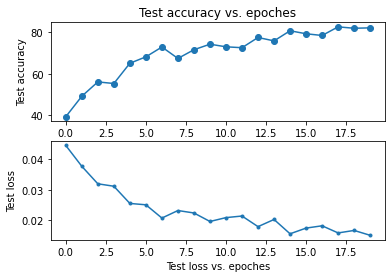

In [1]:
  # --------------------数据展示---------------------------------
import numpy as np
import matplotlib.pyplot as plt
import os

checkPointPath = '../DBtest/checkPoint/ResNet_checkPoint/'

if os.path.exists(checkPointPath + 'loss.npy'):
    Loss_list = np.load(checkPointPath + 'loss.npy', allow_pickle=True)
else:
    Loss_list = []

if os.path.exists(checkPointPath + 'accuracy.npy'):
    Accuracy_list = np.load(checkPointPath + 'accuracy.npy', allow_pickle=True)
else:
    Accuracy_list = []

x1 = range(0, len(Loss_list))
x2 = range(0, len(Loss_list))
y1 = Accuracy_list
y2 = Loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Test loss vs. epoches')
plt.ylabel('Test loss')
plt.show()